In [89]:
#Load libraries

import os
import glob
import torch
import shutil
import pathlib
import matplotlib
import torchvision
import numpy as np
from io import open
import pandas as pd
import torch.nn as nn
from PIL import Image
from pandas import read_csv
import torch.optim as optim
import torch.functional as F
import matplotlib.pyplot as plt
from torch.optim import Adam, SGD
from torch.autograd import Variable
from numpy.random import RandomState
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
from torchvision.models import squeezenet1_1
from torchvision.transforms import transforms
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

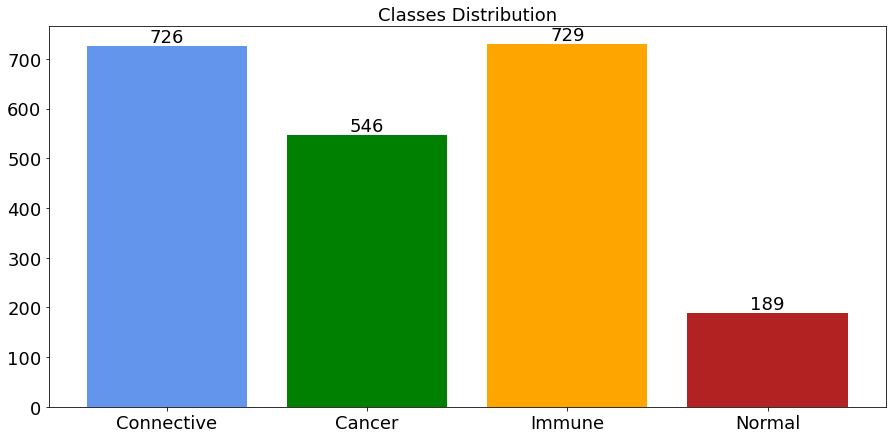

In [55]:
# Check Classes Distribution

train_csv = pd.read_csv('train.csv')

Connective_count = train_csv.Type.str.count("Connective").sum()
Cancer_count = train_csv.Type.str.count("Cancer").sum()
Immune_count = train_csv.Type.str.count("Immune").sum()
Normal_count = train_csv.Type.str.count("Normal").sum()


plt.figure(figsize=(15, 7))

x_com = ("Connective", "Cancer", "Immune", "Normal")
y_com = [Connective_count, Cancer_count, Immune_count, Normal_count]

plt.bar(x_com, y_com, color=["cornflowerblue","g", "orange", "firebrick"])

plt.tick_params(labelsize=18)

plt.title("Classes Distribution", fontsize=18)

for a,b in zip(range(len(x_com)),y_com):
    plt.text(a,b,'%s' % b,ha = 'center',va = 'bottom',fontsize=18)
    
plt.show()

The code below move training images to relevant folders within the train folder. For example connective images are moved to connective folder and cancer images are moved to cancer folder. Also the extra training folder is deleted at the end of the code. In the next step, I am using Data Loader that takes both images and labels from the folders.

In [ ]:
#Moving Files to relevant folders

source_dir = 'train/train'
dest1 = 'train/Normal'
dest2 = 'train/Immune/'
dest3 = 'train/Connective/'
dest4 = 'train/Cancer/'


os.mkdir(dest1)
os.mkdir(dest2)
os.mkdir(dest3)
os.mkdir(dest4)

file_names = os.listdir(source_dir)

train = pd.read_csv('train.csv')
train_x = train['Id'].values
train_y = train['Type'].values

for i in range(len(train_y)):
    string = str(train_x[i])
    str(string)
    string = string + ".png"
    if train_y[i]=='Normal':
        shutil.move(os.path.join(source_dir, string), dest1)

    if train_y[i] == "Connective":
        shutil.move(os.path.join(source_dir, string), dest3)   
        
    if train_y[i] == "Immune":
        shutil.move(os.path.join(source_dir, string), dest2)    
        
    if train_y[i] == "Cancer":
         shutil.move(os.path.join(source_dir, string), dest4)
            
os.rmdir(source_dir)

In [56]:
#Data Augmentation & Normalization

transformer = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees = 90),
    transforms.RandomRotation(degrees = 180),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],
                       [0.5,0.5,0.5])
])

In [57]:
#load Data

train_path = 'train/train'
test_path = 'test/test'

load_train = DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform = transformer),
    batch_size = 64, shuffle = True
)

In [58]:
#Classes Identification

root = pathlib.Path(train_path)
classes = sorted([j.name.split('/')[-1] for j in root.iterdir()])
print(classes)

['Cancer', 'Connective', 'Immune', 'Normal']


In the code below, i tried to increase layers. Also i tried different values for output channel but the number of layers and values below gave best accuracy on both training and testing (Kaggle).

In [59]:
#CNN Layers

class ConvNet(nn.Module):
    def __init__(self,num_classes = 4):
        super(ConvNet,self).__init__()
        
        self.conv1 =nn.Conv2d(in_channels = 3,out_channels = 12, kernel_size = 3,stride = 1,padding = 1)
        self.bn1 = nn.BatchNorm2d(num_features = 12)
        self.relu1 = nn.ReLU()
        
        self.pool = nn.MaxPool2d(kernel_size = 2)
        

        self.conv2 = nn.Conv2d(in_channels = 12, out_channels = 20, kernel_size = 3, stride = 1, padding = 1)
        self.relu2 = nn.ReLU()
    

        self.conv3 = nn.Conv2d(in_channels = 20, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
        self.bn3 = nn.BatchNorm2d(num_features=32)
        self.relu3 = nn.ReLU()
    

        self.fc=nn.Linear(in_features = 32 * 32 * 32, out_features=num_classes)

        
    def forward(self,input):
        output = self.conv1(input)
        output = self.bn1(output)
        output = self.relu1(output)
            
        output= self.pool(output)
            
        output = self.conv2(output)
        output = self.relu2(output)
            
        output = self.conv3(output)
        output = self.bn3(output)
        output = self.relu3(output)
        
        output = output.view(-1,32*32*32)
   
        output = self.fc(output)
            
        return output

In [60]:
#Model
# Here 4 means 4 classes i.e cancer, immune, normal and connective
model = ConvNet(num_classes = 4)

#### In the code below, i tried SGD too but Adam gave slight better accuracy with these settings.
I used L2 loss using the weight_decay parameter to the Optimization function.
Learning rate parameter tweaking together with data augmentation had major impact on accuracy though.

In [61]:
#Setting Parameters

epoch_count = 10
optimizer = Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)
#optimizer = SGD(model.parameters(), lr=0.001, weight_decay=0.0001)
loss_fn = nn.CrossEntropyLoss()

In [62]:
#Counting Train Images

train_count = len(glob.glob(train_path+'/**/*.png'))
print(train_count)

2190


Initially, I split train data into train and validation but it ended up less accuracy because normal class has less data for the model to train on it. So that's why i gave all the training data to the model to learn and predict test images.

In [70]:
#Model training and saving best model

best_accuracy = 0.0

accuracy_plot = []

loss_plot = []

actual_list = []

predicted_list = []

for epoch in range(epoch_count):
    
    model.train()
    train_accuracy = 0.0
    train_loss = 0.0
    
    for i, (images,labels) in enumerate(load_train):

        images = Variable(images)
        labels = Variable(labels)
            
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = loss_fn(outputs,labels)
        loss.backward()
        optimizer.step()
        
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction = torch.max(outputs.data,1)
        
       
        
        train_accuracy+=int(torch.sum(prediction == labels.data))
        
        actual_list.append(labels.data.tolist())
        predicted_list.append(prediction.tolist())
        
    train_accuracy = train_accuracy/train_count
    train_loss = train_loss/train_count
    print('Epoch: ' + str(epoch) + ' Train Loss: ' + str(train_loss) + ' Train Accuracy: ' + str(train_accuracy))
    accuracy_plot.append(train_accuracy)
    loss_plot.append(train_loss)
    
    
    #Save the best model
    if train_accuracy > best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint.model')
        best_accuracy = train_accuracy 

Epoch: 0 Train Loss: tensor(0.5665) Train Accuracy: 0.7547945205479452
Epoch: 1 Train Loss: tensor(0.5549) Train Accuracy: 0.7625570776255708
Epoch: 2 Train Loss: tensor(0.5582) Train Accuracy: 0.7611872146118721
Epoch: 3 Train Loss: tensor(0.5545) Train Accuracy: 0.7611872146118721
Epoch: 4 Train Loss: tensor(0.5564) Train Accuracy: 0.7634703196347032
Epoch: 5 Train Loss: tensor(0.5439) Train Accuracy: 0.7771689497716895
Epoch: 6 Train Loss: tensor(0.5450) Train Accuracy: 0.7785388127853882
Epoch: 7 Train Loss: tensor(0.5421) Train Accuracy: 0.7712328767123288
Epoch: 8 Train Loss: tensor(0.5609) Train Accuracy: 0.7534246575342466
Epoch: 9 Train Loss: tensor(0.5465) Train Accuracy: 0.7680365296803653


In [71]:
#Load the best model

checkpoint = torch.load('best_checkpoint.model')
model = ConvNet(num_classes = 4)
model.load_state_dict(checkpoint)
model.eval()

ConvNet(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (conv3): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (fc): Linear(in_features=32768, out_features=4, bias=True)
)

In [90]:
#Confusion Matrix

actual_list = [item for sublist in actual_list for item in sublist]
predicted_list = [item for sublist in predicted_list for item in sublist]

matrix = confusion_matrix(actual_list,predicted_list)
print('Confusion matrix : \n',matrix)

matrix = classification_report(actual_list,predicted_list)
print('\n\nClassification report : \n',matrix)

Confusion matrix : 
 [[4389  524  323  224]
 [ 512 4776 1936   36]
 [  51  469 6768    2]
 [ 707  186  173  824]]


Classification report : 
               precision    recall  f1-score   support

           0       0.78      0.80      0.79      5460
           1       0.80      0.66      0.72      7260
           2       0.74      0.93      0.82      7290
           3       0.76      0.44      0.55      1890

    accuracy                           0.77     21900
   macro avg       0.77      0.71      0.72     21900
weighted avg       0.77      0.77      0.76     21900



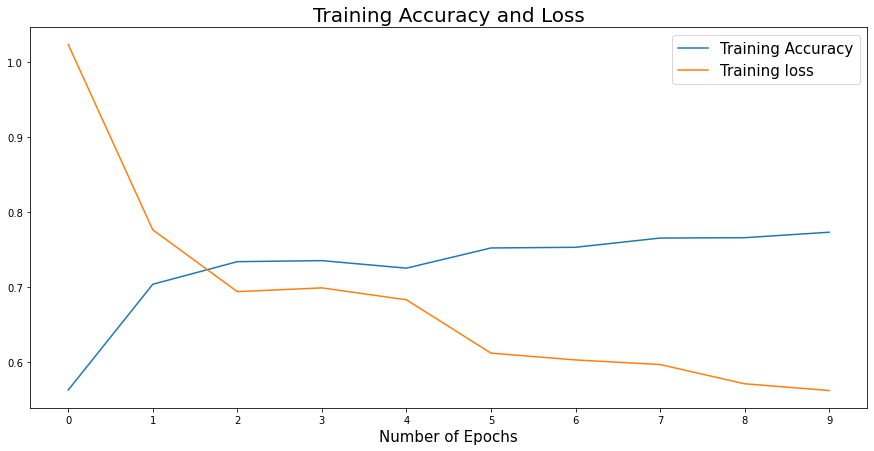

In [47]:
#Plotting Training Accuracy and Loss

plt.plot(accuracy_plot, label='Training Accuracy')
plt.plot(loss_plot, label='Training loss')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(15, 7, forward=True)
plt.title("Training Accuracy and Loss", fontsize=20)
plt.xticks(np.arange(0, 10, step=1))
plt.xlabel("Number of Epochs", fontsize=15)
plt.legend(loc=1, fontsize=15)
plt.show()

In [13]:
#Image Prediction Function

def prediction(img_path,transformer):
    
    image = Image.open(img_path)
    
    image_tensor = transformer(image).float() 
    
    image_tensor = image_tensor.unsqueeze_(0)
        
    input = Variable(image_tensor)
      
    output = model(input)
    
    index = output.data.numpy().argmax()
    
    pred = classes[index]
    
    return pred

In [14]:
#Setting Test Images Path

images_path = glob.glob(test_path+'/*.png')

In [15]:
#Making dictionary of predictions

pred_dict = {}

for i in images_path:
    pred_dict[i[i.rfind('/')+1:]] = prediction(i,transformer) 

In [16]:
#Making CSV of predictions

import csv

a_file = open("test.csv", "w", newline = '')

writer = csv.writer(a_file)

writer.writerow(["Id", "Type"])

for key, value in pred_dict.items():
    key = key.split("\\")
    key = key[1].split(".")
    writer.writerow([key[0], value])  

a_file.close()

print("Check CSV File Now")

Check CSV File Now
